# Looking at Switchiness

In [1]:
cd ..

/cellar/users/agross/TCGA_Code/DX/Notebooks


In [2]:
import NotebookImport
from DX_screen import *

importing IPython notebook from DX_screen

importing IPython notebook from Imports

importing IPython notebook from /cellar/users/agross/anaconda2/lib/python2.7/site-packages/MethylTools/Probe_Annotations

In [3]:
cd ../DX/Notebooks/

/cellar/users/agross/TCGA_Code/DX/Notebooks


In [4]:
from Imports import *
from Preprocessing.ClinicalDataFilters import *

importing IPython notebook from Preprocessing/ClinicalDataFilters

importing IPython notebook from Preprocessing/ClinicalData

PCPG
UCS
TGCT
CHOL
THYM
MESO
FPPP


/cellar/users/agross/anaconda2/lib/python2.7/site-packages/Processing/ProcessClinicalDataPortal.py:37: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead
  f['vitalstatus'] = f['daystodeath'].isnull()


#### Reconstruct meta-PCNA signature

In [303]:
g = ['PCNA', 'CKS2', 'NUSAP1', 'RRM2', 'ZWINT', 
     'PRC1', 'TFDP1', 'CCNA2', 'CCNB1', 'MELK', 
     'TPX2', 'BIRC5', 'NCAPG2', 'RFWD3', 'TACC3', 
     'KIAA0101', 'MCM2', 'MCM5', 'ASF1B', 'CCNB2', 
     'GTPBP2', 'KIF20A', 'PTTG1', 'AURKA', 'CDC20', 
     'FOXM1', 'GINS2', 'MAD2L1', 'UBE2C', 'GINS1', 
     'MCM6', 'NCAPD2', 'NUP37', 'CKS1B', 'MCM7', 
     'ARID3A', 'AURKB', 'CDCA8', 'SNRPD1', 'TROAP', 
     'C21orf45', 'DDX39', 'ESPL1', 'HMBS', 'LSM6', 
     'MCM4', 'NCAPD3', 'PPIH', 'DTL', 'EPB42', 'HMGN2',
     'MCM3', 'PF4', 'PPBP', 'RFC4', 'TOP2A', 'BUB1B', 
     'CDT1', 'FEN1', 'GATA1', 'GYPB', 'HMGB2', 'KIF22', 
     'KLF1', 'MLF1IP', 'RFC3', 'RHCE', 'TAL1', 'TCF3', 
     'ALAS2', 'CDCA3', 'CENPA', 'CKLF', 'GTSE1', 
     'NFE2', 'OIP5', 'SHCBP1', 'SNF8', 'SNRPB', 'SPTA1', 
     'KEL', 'KIF2C', 'LYL1', 'PSMD9', 'RACGAP1', 'RPIA',
     'TIMELESS', 'TRMT5', 'TYMS', 'VRK1', 'FBXO7', 'H3F3A',
     'NUDT1', 'PLEK', 'POLE2', 'RHAG', 'WHSC1', 'APOBEC3B', 
     'BPGM', 'CHAF1A', 'DNAJC9', 'FBXO5', 'KIF4A', 'KLF15', 
     'MKI67', 'PGD', 'RPA3', 'SFRS2', 'TRIM58', 'ADAMTS13', 
     'CDCA4', 'CDKN3', 'FECH', 'LBR', 'LIG1', 'LMNB1', 'MICB', 
     'NUP210', 'ORC6L', 'RAD51AP1', 'RHD', 'SMC4', 'GYPA', 
     'RPP30', 'TRIM10']
meta_pcna = rna_df.ix[g].median()[:,'01']
meta_pcna.name = 'meta_pcna'
len(meta_pcna)

9051

In [308]:
mp2 = matched_rna.ix[g].median()
mp2.name = 'meta_pcna'
len(mp2)

1338

In [321]:
rna_sig = pd.read_csv('/cellar/users/agross/TCGA_Code/DX/rna_signature.csv',
                      index_col=[0,1], header=None, squeeze=True)
#rna_sig = rna_sig[:,1]
rna_sig.index.name = ''
rna_sig.index = pd.MultiIndex.from_tuples([(i[0], '0' + str(i[1]) 
                                           if len(str(i[1])) == 1 else str(i[1]))
                                          for i in rna_sig.index])

In [324]:
m2 = rna_sig[matched_rna.columns]

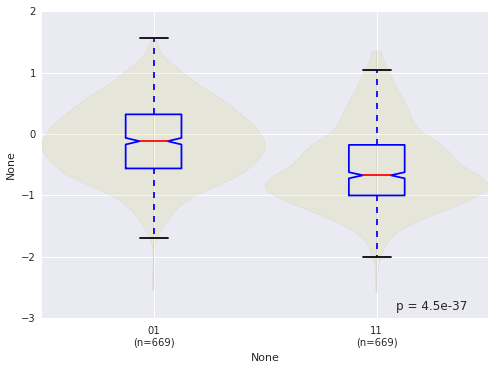

In [327]:
violin_plot_series(standardize(m2) - standardize(mp2))

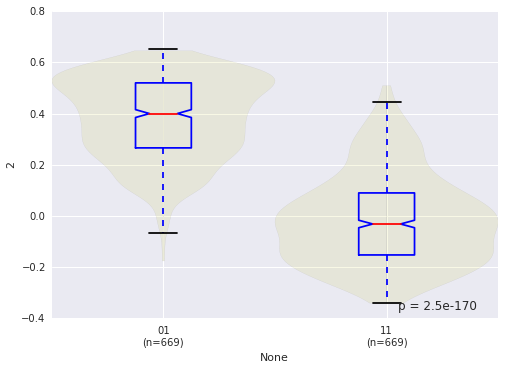

In [323]:
violin_plot_series(rna_sig[matched_rna.columns])

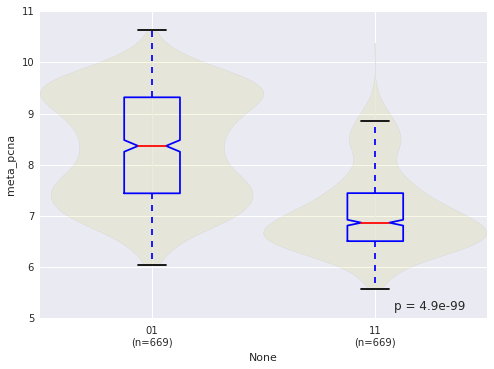

In [309]:
violin_plot_series(mp2)

#### Generate gene-level coorelation with meta-PCNA

In [6]:
standardize = lambda s: s.sub(s.median(1), axis=0).div(s.mad(1), axis=0)
df = rna_df.xs('01',1,1)
df_s = df.groupby(codes, axis=1).apply(standardize)
mp2 = meta_pcna.groupby(codes).apply(standardize).dropna()

pcna_corr = df_s.T.corrwith(mp2)

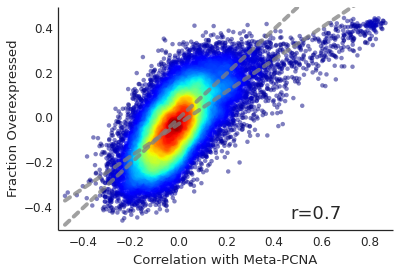

In [7]:
fig, ax = subplots()
f = pcna_corr
plot_regression(f, dx_rna.frac - .5, density=True, rad=.03, s=20,
                rasterized=True, ax=ax)
ax.set_ybound(-.5,.5)
ann = ax.get_children()[4]
ann.set_text(ann.get_text().split()[0])
ax.set_ylabel('Fraction Overexpressed')
ax.set_xlabel('Correlation with Meta-PCNA')

#### Normalize out effect of meta-PCNA from fraction overexpressed

In [57]:
m = pd.rolling_mean(dx_rna.frac.ix[pcna_corr.order().index].dropna(), 
                    window=500, center=True).dropna()
m2 = pd.rolling_mean(dx_rna.frac.ix[pcna_corr.order().index].dropna(), 
                    window=50, center=True).dropna()
m = m.combine_first(m2)
f_win = (dx_rna.frac - m).dropna()
f_win.name = 'fraction overexpressed\n(detrended)'

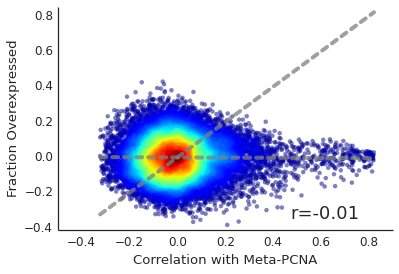

In [9]:
fig, ax = subplots()
f = pcna_corr
plot_regression(f, f_win, density=True, rad=.03, s=20,
                rasterized=True, ax=ax)
ax.set_xbound(-.5,.9)
ann = ax.get_children()[4]
ann.set_text(ann.get_text().split()[0])
ax.set_ylabel('Fraction Overexpressed')
ax.set_xlabel('Correlation with Meta-PCNA')

In [331]:
f_win.order().tail(10)[::-1]

GABRD      0.43
CHPF       0.43
CHPF2      0.41
SEZ6L2     0.39
CST2       0.39
CST1       0.38
PLEKHN1    0.38
MMP11      0.37
LPPR2      0.37
CST4       0.37
Name: fraction overexpressed\n(detrended), dtype: float64

In [55]:
m = pd.rolling_mean(pcna_corr.ix[dx_rna.frac.order().index].dropna(), 
                    window=500, center=True).dropna()
m2 = pd.rolling_mean(pcna_corr.ix[dx_rna.frac.order().index].dropna(), 
                    window=50, center=True).dropna()
m = m.combine_first(m2)
pcna_win = (pcna_corr - m).dropna()
pcna_win.name = 'meta-PCNA\n(detrended)'

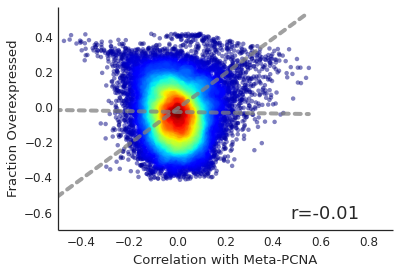

In [42]:
fig, ax = subplots()
plot_regression(pcna_win, dx_rna.frac - .5, density=True, rad=.03, s=20,
                rasterized=True, ax=ax)
ax.set_xbound(-.5,.9)
ann = ax.get_children()[4]
ann.set_text(ann.get_text().split()[0])
ax.set_ylabel('Fraction Overexpressed')
ax.set_xlabel('Correlation with Meta-PCNA')

In [199]:
np.arctan2(-3.5, 5.4)

-0.57507228973239055

In [246]:
s1.ix['SFRS3']

-0.41507264489024115

In [247]:
s2.ix['SFRS3']

3.7518211976810973

In [131]:
pcna_corr.ix['IBSP']

0.14760248575513746

In [275]:
df = pd.concat([(theta / (2*np.pi)) * 360 % 360, r], 1).sort(1)

In [276]:
df[(df[0] > 45) & (df[0] < 90)].tail(10)

,0,1
GBX2,62.24,3.19
CELSR3,57.92,3.23
PPP1R14B,47.90,3.23
TMEM132A,67.99,3.27
SPATS2,51.53,3.28
C16orf88,46.85,3.31
GPR172A,54.32,3.33
IBSP,64.22,3.49
MMP11,77.35,3.51
GPRIN1,47.11,3.53


In [271]:
df[(df[0] > 90) & (df[0] < 135)].tail(10)

,0,1
CHPF,124.35,2.39
MC1R,92.84,2.43
ZDHHC9,98.56,2.46
CST4,102.47,2.54
PLEKHN1,101.99,2.58
SEZ6L2,109.14,2.61
CST2,105.70,2.63
CST1,94.84,2.85
CHPF2,101.13,2.98
GABRD,102.07,3.04


In [274]:
df[(df[0] > 270) & (df[0] < 315)].tail(10)

,0,1
DPH3,282.63,2.08
RALYL,278.17,2.10
SUCLG1,297.70,2.12
POU3F4,276.81,2.13
PTX3,285.84,2.14
HADH,285.52,2.18
PCOLCE2,288.96,2.22
ITLN1,274.37,2.25
HFM1,270.34,2.25
XAGE2,287.77,2.42


In [297]:
df[(df[0] > 315) & (df[0] < 345)].tail(10)

,0,1
C1orf52,341.90,2.15
BCAS2,340.33,2.20
HNRNPH3,331.70,2.21
USP13,343.03,2.22
ZNF833,336.09,2.33
CTNNAL1,324.31,2.37
TOE1,342.22,2.41
WEE1,343.56,2.46
KATNA1,344.03,2.70
PSIP1,334.57,2.90


In [286]:
df.sort(1).tail()

,0,1
CHTF18,34.26,4.48
SFRS1,17.66,4.50
C13orf27,10.53,4.50
HMGB3,27.79,4.51
SIP1,15.11,4.51


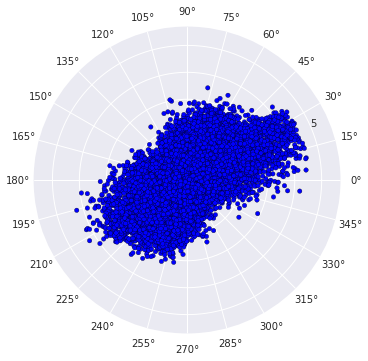

In [295]:
ax = plt.subplot(111,polar=True)

s1 = standardize(dx_rna.frac)
s2 = standardize(pcna_corr.ix[ti(pcna_corr.abs() < .4)])
s1, s2 = match_series(s1, s2)

theta = np.arctan2(s1, s2)
r = pd.concat([s1.abs(), s2.abs()],1).max(1)
theta, r = match_series(theta, r)
plt.scatter(theta, r);
ax.set_thetagrids(range(0,360, 15));

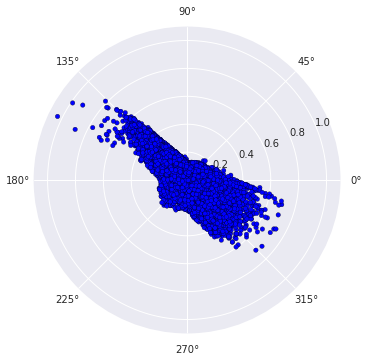

In [206]:
ax = plt.subplot(111, polar=True)

s1 = standardize(f_win)
s2 = standardize(pcna_win)
s1, s2 = match_series(s1, s2)
theta = np.arctan2(s1, s2)
r = f_win.abs() + pcna_win.abs()
theta, r = match_series(theta, r)
plt.scatter(theta, r);

In [222]:
rad = (theta / (2*np.pi)) * 360 % 360

In [227]:
dd = pd.concat([rad - 135, rad - 315], 1).abs().min(1)

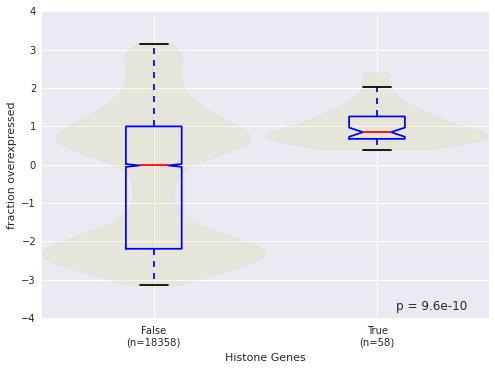

In [238]:
violin_plot_pandas(hist, theta)

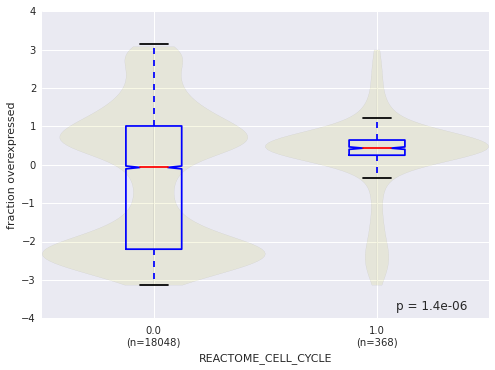

In [237]:
violin_plot_pandas(gs2['REACTOME_CELL_CYCLE'], theta)

In [ ]:
sns.xkcd_palette

In [209]:
df = pd.concat([(theta / (2*np.pi)) * 360 % 360, r], 1).sort(1)
df[df[0] < 180].tail(20)

,0,1
GBX2,150.53,0.67
RNF187,135.91,0.67
ZNF668,141.38,0.67
GPRIN1,155.18,0.68
LPPR2,133.96,0.68
CST4,134.52,0.69
GPR172A,154.07,0.70
PLEKHN1,135.15,0.71
CST1,134.95,0.72
PLXNA3,142.22,0.72


In [192]:
df = pd.concat([(theta / (2*np.pi)) * 360 % 360, r], 1).sort(1)
df[df[0] > 270].tail()

,0,1
HMGB2,343.14,0.70
SFRS3,271.52,0.71
SFRS7,302.11,0.71
PSIP1,300.91,0.72
TRA2B,327.31,0.73


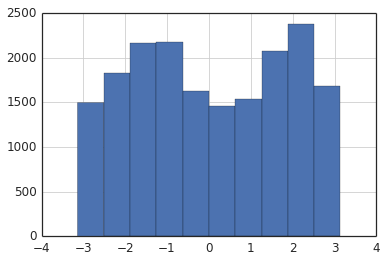

In [75]:
np.arctan2(f_win, pcna_win).hist()

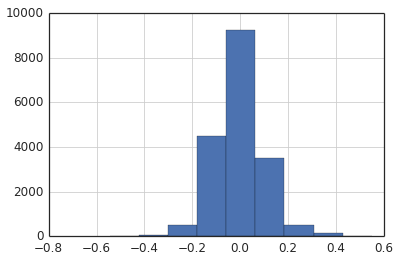

In [72]:
pcna_win.hist()

In [64]:
gs2 = gene_sets.ix[f_win.index].fillna(0)
r2 = screen_feature(pcna_win, rev_kruskal, gs2.T, 
                    align=False)
fp = (1.*gene_sets.T * pcna_win).T.dropna().replace(0, np.nan).mean().order()
fp.name = 'mean frac'

In [65]:
r2.ix[ti(fp > 0)].join(fp).sort('p').head(6)

,H,p,q,mean frac
Gene_Set,,,,
REACTOME_CELL_CYCLE_MITOTIC,246.70,1.36e-55,1.81e-52,0.12
REACTOME_CELL_CYCLE,220.47,7.14e-50,4.75e-47,0.10
REACTOME_DNA_REPLICATION,209.03,2.24e-47,9.93e-45,0.15
REACTOME_MITOTIC_M_M_G1_PHASES,190.11,3.00e-43,9.98e-41,0.15
REACTOME_MRNA_PROCESSING,127.19,1.69e-29,4.50e-27,0.11
REACTOME_PROCESSING_OF_CAPPED_INTRON_CONTAINING_PRE_MRNA,125.88,3.27e-29,7.24e-27,0.12


In [69]:
r2.ix[ti(fp < 0)].join(fp).sort('p').head(10)

,H,p,q,mean frac
Gene_Set,,,,
NABA_MATRISOME,62.76,2.33e-15,1.11e-13,-0.03
KEGG_LYSOSOME,62.70,2.41e-15,1.11e-13,-0.07
NABA_CORE_MATRISOME,58.21,2.36e-14,9.23e-13,-0.05
REACTOME_EXTRACELLULAR_MATRIX_ORGANIZATION,53.22,2.98e-13,9.67e-12,-0.08
KEGG_ECM_RECEPTOR_INTERACTION,40.06,2.47e-10,5.38e-09,-0.07
PID_INTEGRIN1_PATHWAY,37.26,1.04e-09,1.97e-08,-0.07
NABA_ECM_REGULATORS,36.22,1.77e-09,3.22e-08,-0.05
REACTOME_POST_TRANSLATIONAL_PROTEIN_MODIFICATION,34.81,3.63e-09,6.27e-08,-0.04
REACTOME_COLLAGEN_FORMATION,33.37,7.62e-09,1.24e-07,-0.07


In [328]:
import seaborn as sns
sns.set_context('paper',font_scale=1.5)
sns.set_style('white')

#### Look for gene sets associated with switchiness

In [11]:
gs2 = gene_sets.ix[f_win.index].fillna(0)
r2 = screen_feature(f_win, rev_kruskal, gs2.T, 
                    align=False)
fp = (1.*gene_sets.T * f_win).T.dropna().replace(0, np.nan).mean().order()
fp.name = 'mean frac'

In [12]:
r2.ix[ti(fp > 0)].join(fp).sort('p').head(6)

,H,p,q,mean frac
Gene_Set,,,,
KEGG_LYSOSOME,59.09,1.50e-14,2.00e-11,0.08
REACTOME_POST_TRANSLATIONAL_PROTEIN_MODIFICATION,49.00,2.57e-12,1.71e-09,0.06
REACTOME_METABOLISM_OF_PROTEINS,45.08,1.89e-11,8.38e-09,0.03
REACTOME_RNA_POL_I_PROMOTER_OPENING,41.98,9.24e-11,3.07e-08,0.10
REACTOME_PACKAGING_OF_TELOMERE_ENDS,35.15,3.05e-09,6.72e-07,0.11
REACTOME_RNA_POL_I_TRANSCRIPTION,34.62,4.02e-09,6.72e-07,0.07


In [13]:
r2.ix[ti(fp < 0)].join(fp).sort('p').head(3)

,H,p,q,mean frac
Gene_Set,,,,
REACTOME_TCA_CYCLE_AND_RESPIRATORY_ELECTRON_TRANSPORT,38.26,6.20e-10,1.65e-07,-0.06
KEGG_FATTY_ACID_METABOLISM,32.04,1.51e-08,2.01e-06,-0.11
KEGG_PROPANOATE_METABOLISM,29.85,4.66e-08,5.41e-06,-0.11


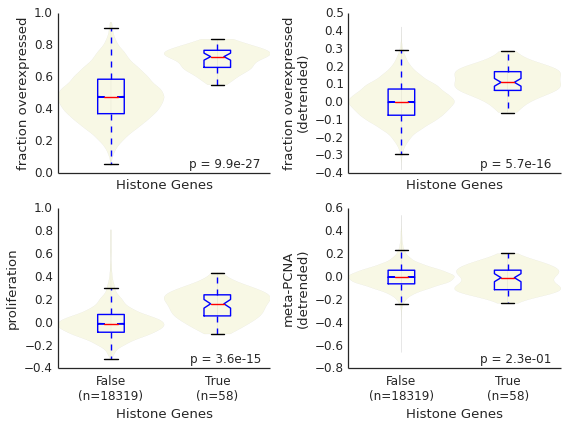

In [329]:
p = hist
fig, axs = subplots(2,2, figsize=(8,6), sharex=True)
axs = axs.flatten()
violin_plot_pandas(p, dx_rna.frac, ax=axs[0])
violin_plot_pandas(p, pcna_corr, ax=axs[2])
violin_plot_pandas(p, f_win, ax=axs[1])
violin_plot_pandas(p, pcna_win, ax=axs[3])
for ax in axs:
    prettify_ax(ax)
fig.tight_layout()

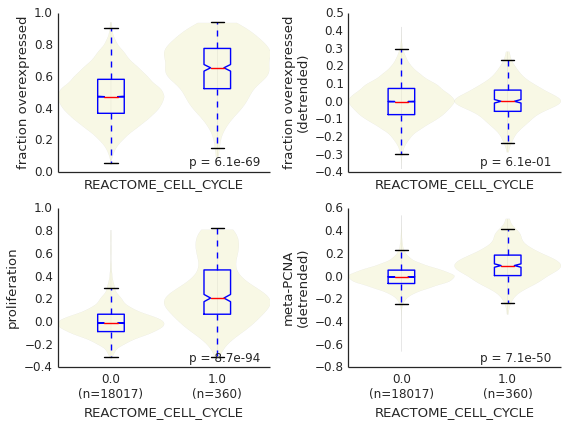

In [330]:
p = gs2['REACTOME_CELL_CYCLE']
fig, axs = subplots(2,2, figsize=(8,6), sharex=True)
axs = axs.flatten()
violin_plot_pandas(p, dx_rna.frac, ax=axs[0])
violin_plot_pandas(p, pcna_corr, ax=axs[2])
violin_plot_pandas(p, f_win, ax=axs[1])
violin_plot_pandas(p, pcna_win, ax=axs[3])
for ax in axs:
    prettify_ax(ax)
fig.tight_layout()

The promoter opening and the telomere gene sets look similar here I pick the apart... it seems as though they generally share a bunch of histones and that is where the enrichment occurs.

In [14]:
gg = combine(gs2['REACTOME_RNA_POL_I_PROMOTER_OPENING']>0, 
       gs2['REACTOME_PACKAGING_OF_TELOMERE_ENDS']>0)
gg = gg.replace({'REACTOME_RNA_POL_I_PROMOTER_OPENING': 'pol 1',
                 'REACTOME_PACKAGING_OF_TELOMERE_ENDS': 'telomere'})
gg.name = ''
pcna_corr.name = 'proliferation'
f_win.name = 'detrended f_up'

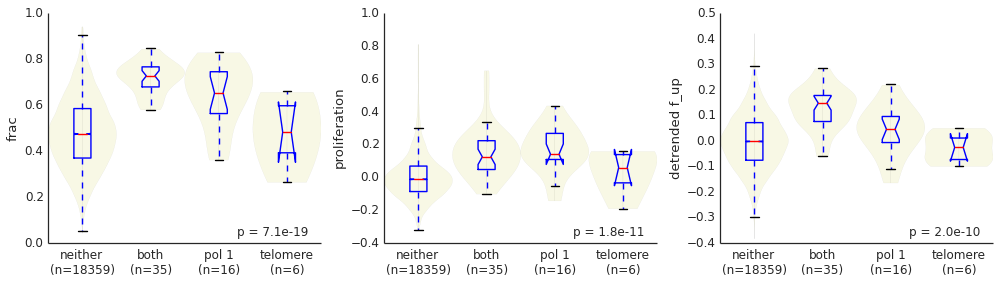

In [15]:
fig, axs = subplots(1,3, figsize=(14,4))
violin_plot_pandas(gg, dx_rna.frac, ax=axs[0])
violin_plot_pandas(gg, pcna_corr, ax=axs[1])
violin_plot_pandas(gg, f_win, ax=axs[2])
for ax in axs:
    prettify_ax(ax)
fig.tight_layout()

In [16]:
f_win.ix[ti(gg == 'both')].order()[::-1]

HIST2H2AA3    0.29
HIST1H4J      0.27
HIST1H2BD     0.26
HIST1H4K      0.21
HIST1H2AE     0.21
HIST1H2AC     0.20
HIST3H2BB     0.19
HIST1H2BE     0.19
HIST1H2BK     0.18
HIST4H4       0.18
HIST1H2BN     0.17
HIST2H2BE     0.17
HIST1H4H      0.16
HIST1H2BM     0.16
HIST1H2BC     0.16
HIST1H2AJ     0.16
HIST1H2BG     0.15
HIST1H4E      0.15
HIST1H2BF     0.15
HIST2H4A      0.12
HIST1H2BO     0.10
HIST1H2BH     0.10
HIST1H2AD     0.10
HIST1H2BL     0.09
HIST1H2BI     0.09
HIST1H2BJ     0.08
HIST1H4A      0.08
H2AFX         0.07
HIST1H2AB     0.07
HIST1H4I      0.06
HIST1H4D      0.05
HIST1H4B      0.01
HIST2H2AC    -0.01
H2AFZ        -0.06
HIST1H4C     -0.06
Name: detrended f_up, dtype: float64

Here I try and break down the histones, there doesn't seem to be much of a difference between the subunits

In [22]:
g = pd.Series(f_win.index, f_win.index)
hist = g.str.startswith('HIST')

h2 = g.ix[ti(hist)].map(lambda s: s[:6])
h3 = g.ix[ti(hist)].map(lambda s: s[:7])
h3 = g.ix[ti(h3.isin(ti(h3.value_counts() > 5)))].map(lambda s: s[:7])
h4 = g.ix[ti(hist)].map(lambda s: s[:8])
h4 = g.ix[ti(h4.isin(ti(h4.value_counts() > 2)))].map(lambda s: s[:8])
h5 = g.ix[ti(hist)].map(lambda s: s[:10])
h5 = g.ix[ti(h5.isin(ti(h5.value_counts() > 2)))].map(lambda s: s[:10])
h6 = h5.ix[h2.index].combine_first(h4.ix[h2.index].combine_first(h3.ix[h2.index].combine_first(h2)))
h6.value_counts()

HIST1H2B    13
HIST1H2A    10
HIST1H4      9
HIST1H3      9
HIST1H       5
HIST2H       3
HIST2H2B     3
HIST2H2A     3
HIST3H       2
HIST4H       1
dtype: int64

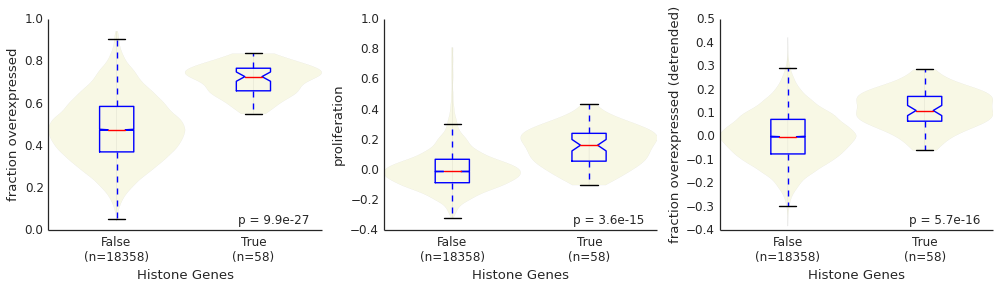

In [32]:
fig, axs = subplots(1,3, figsize=(14,4))
ff = dx_rna.frac
ff.name = 'fraction overexpressed'
f_win.name = 'fraction overexpressed (detrended)'
hist.name = 'Histone Genes'
violin_plot_pandas(hist, dx_rna.frac, ax=axs[0])
violin_plot_pandas(hist, pcna_corr, ax=axs[1])
violin_plot_pandas(hist, f_win, ax=axs[2])
for ax in axs:
    prettify_ax(ax)
fig.tight_layout()

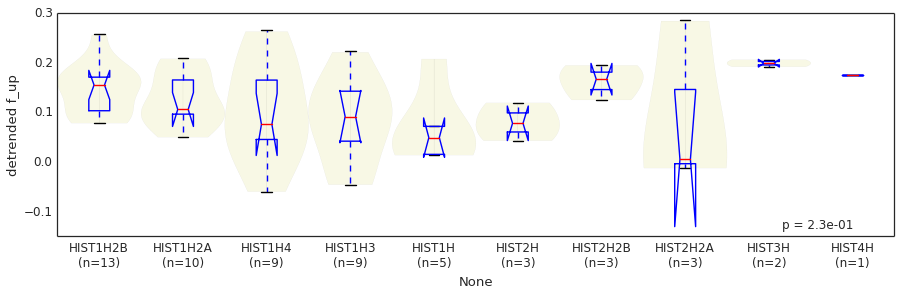

In [23]:
fig, ax = subplots(figsize=(15,4))
violin_plot_pandas(h6, f_win, ax=ax)

### Compare meta-PCNA to the tumorness signature

In [80]:
rna_sig = pd.read_csv('/cellar/users/agross/TCGA_Code/DX/rna_signature.csv',
                      index_col=[0,1], header=None, squeeze=True)
rna_sig = rna_sig[:,1]
rna_sig.index.name = ''

In [390]:
rna_sig.name = 'tumorness'
f = 'Surv(days, event) ~ meta_pcna + tumorness + strata(codes) + age + tumorness:meta_pcna'
m1 = get_cox_ph(surv_5y, covariates=[meta_pcna, rna_sig, codes, age], formula=f, 
                interactions=False, print_desc=True);

f = 'Surv(days, event) ~ meta_pcna + strata(codes) + age'
m2 = get_cox_ph(surv_5y, covariates=[meta_pcna, rna_sig, codes, age], formula=f, 
                interactions=False, print_desc=True);
LR_test(m1, m2)


                      coef exp(coef) se(coef)     z       p
meta_pcna            0.222      1.25   0.0569  3.90 9.7e-05
tumorness            0.432      1.54   0.0646  6.70 2.1e-11
age                  0.371      1.45   0.0300 12.35 0.0e+00
meta_pcna:tumorness -0.175      0.84   0.0383 -4.56 5.1e-06

Likelihood ratio test=350  on 4 df, p=0  n= 8478, number of events= 1889 


           coef exp(coef) se(coef)    z p
meta_pcna 0.480      1.62   0.0441 10.9 0
age       0.381      1.46   0.0299 12.7 0

Likelihood ratio test=278  on 2 df, p=0  n= 8478, number of events= 1889 



2.2726347465790636e-16

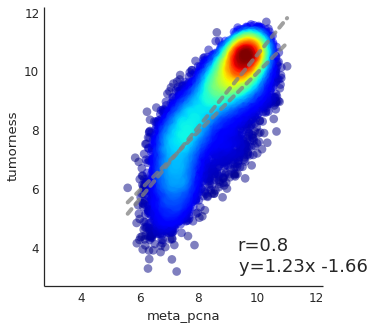

In [397]:
plot_regression(meta_pcna, rna_sig*10 + 5, density=True, rad=.5)

In [402]:
f_adj = meta_pcna.dropna()
f_adj = detrend(f_adj, rna_sig)
f_adj = f_adj - meta_pcna
f_adj = f_adj.dropna()

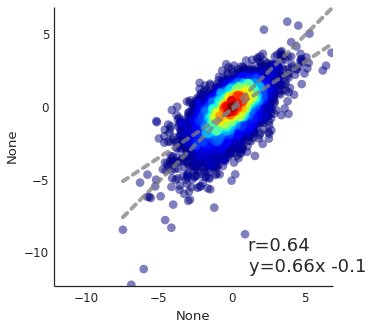

In [406]:
mc = meta_pcna.groupby(codes).apply(standardize)
fc = rna_sig.groupby(codes).apply(standardize)
plot_regression(mc, fc, density=True, rad=.1)

In [407]:
f_adj_c = detrend(mc.dropna(), fc)
f_adj_c = f_adj_c - mc
f_adj_c = f_adj_c.groupby(codes).apply(standardize)
f_adj_c = f_adj_c.dropna()

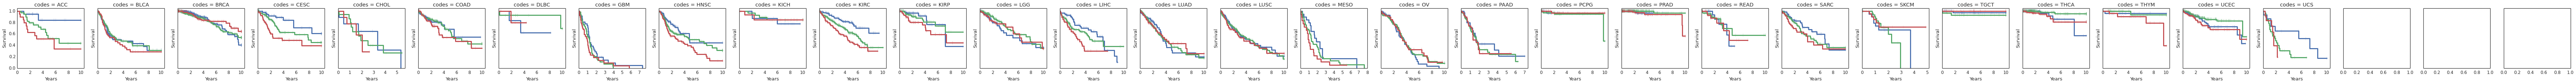

In [408]:
draw_survival_curves(f_adj_c, surv_10y, codes)

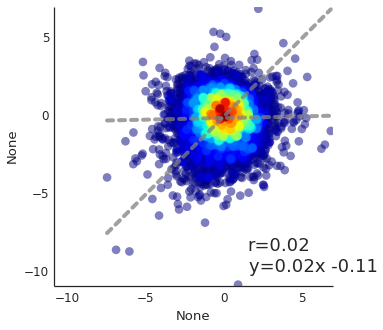

In [409]:
plot_regression(mc, f_adj_c, density=True, rad=.1)

In [410]:
mc.name = 'meta_pcna'
f_adj_c.name = 'f'
f = 'Surv(days, event) ~ meta_pcna + f + strata(codes) + age'
m1 = get_cox_ph(surv_5y, covariates=[mc, f_adj_c, codes, age], formula=f, 
                interactions=False, print_desc=True);

f = 'Surv(days, event) ~ meta_pcna + strata(codes) + age'
m2 = get_cox_ph(surv_5y, covariates=[mc, f_adj_c, codes, age], formula=f, 
                interactions=False, print_desc=True);
LR_test(m1, m2)


           coef exp(coef) se(coef)     z       p
meta_pcna 0.242      1.27   0.0246  9.81 0.0e+00
f         0.164      1.18   0.0252  6.53 6.5e-11
age       0.373      1.45   0.0300 12.45 0.0e+00

Likelihood ratio test=296  on 3 df, p=0  n= 8478, number of events= 1889 


           coef exp(coef) se(coef)     z p
meta_pcna 0.235      1.26   0.0244  9.64 0
age       0.379      1.46   0.0300 12.64 0

Likelihood ratio test=252  on 2 df, p=0  n= 8478, number of events= 1889 



3.4629108988469306e-11

### Try and associate switchiness with mutations and copy number events

In [ ]:
mut_all = pd.read_csv('/cellar/users/agross/TCGA_Code/CancerData/Data/MAFs_new_4/meta.csv', 
                      index_col=[1,2])
mut = mut_all['0'].unstack().fillna(0)
mut = FH.fix_barcode_columns(mut)
mut = mut.xs('01', axis=1, level=1)

mut = mut.ix[rna_df.index]
mut_rate = (mut>0).mean().order()
mut = mut.ix[:, ti(mut_rate < .1)] #filter samples with lots of mutations
mut.shape

In [ ]:
path = '/cellar/users/agross/TCGA_Code/CancerData/Data/Firehose__2015_04_02/'
cn = {}
for c in cancers:
    try:
        gg = FH.get_gistic_gene_matrix(path, c)
        gg.index = gg.index.get_level_values('Gene Symbol')
        cn[c] = gg
    except:
        print c
cn = pd.concat(cn.values(), axis=1)
cn = cn.groupby(level=0).first()
#cn = cn == -2

In [411]:
df = mut.ix[:, ti(codes=='THCA')]
df = df[(df > 0).sum(1) > 7]
df.shape

(52, 505)

In [416]:
rr = screen_feature(f_adj_c, rev_kruskal, df>0, align=False)

In [443]:
rr.head(10)

,H,p,q
BRAF,48.71,2.97e-12,1.54e-10
NRAS,15.57,7.93e-05,2.06e-03
HRAS,7.48,6.23e-03,1.08e-01
ANKRD20B,6.22,1.26e-02,1.64e-01
TPTE,5.54,1.86e-02,1.94e-01
LOC374491,4.83,2.80e-02,2.42e-01
LOC100133050,3.31,6.87e-02,3.97e-01
MUC16,3.11,7.78e-02,3.97e-01
CROCCL1,2.88,8.97e-02,3.97e-01
RPL13AP20,2.88,8.97e-02,3.97e-01


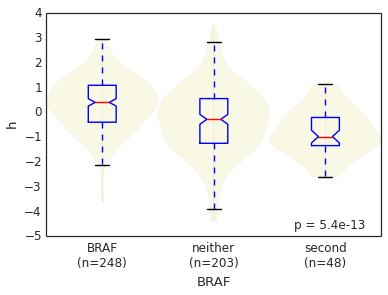

In [442]:
violin_plot_pandas(combine(df.ix['BRAF']>0, 
                           df.ix[['HRAS','KRAS','NRAS']].sum()>0), 
                   f_adj_c.clip(-5,5))

In [450]:
df = mut.ix[:, ti(codes=='LUAD')]
df = df[(df > 0).sum(1) > 25]
df.shape

(748, 521)

In [451]:
rr = screen_feature(f_adj_c, rev_kruskal, df>0, align=False)

In [452]:
rr.head()

,H,p,q
KRAS,17.30,3.20e-05,0.02
RB1,15.44,8.50e-05,0.03
DCHS2,11.55,6.77e-04,0.17
MYH6,10.71,1.06e-03,0.19
STK11,10.41,1.25e-03,0.19


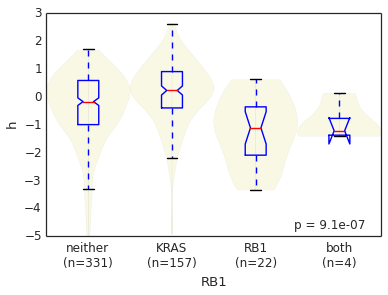

In [455]:
violin_plot_pandas(combine(df.ix['RB1']>0, df.ix['KRAS']>0), 
                   f_adj_c.clip(-5,5))

In [459]:
df = mut.ix[:, ti(codes=='CESC')]
df = df[(df > 0).sum(1) > 15]
df.shape

(81, 305)

In [460]:
rr = screen_feature(f_adj_c, rev_kruskal, df>0, align=False)
rr.head()

,H,p,q
PIK3CA,5.62,0.02,0.85
MYH9,4.74,0.03,0.85
MUC5B,3.93,0.05,0.85
DNAH6,3.14,0.08,0.85
CREBBP,2.97,0.08,0.85


In [463]:
df = mut.ix[:, ti(codes=='LIHC')]
df = df[(df > 0).sum(1) > 15]
df.shape

(155, 363)

In [464]:
rr = screen_feature(f_adj_c, rev_kruskal, df>0, align=False)
rr.head()

,H,p,q
ZAN,8.62,0.00,0.47
TP53,7.04,0.01,0.47
MUC2,6.74,0.01,0.47
NBPF1,6.30,0.01,0.47
KCP,5.26,0.02,0.63
